In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### CAvideos.csv

In [2]:
csv_path = "CAvideos.csv"
csv_cols = ['video_id', 'channel_title', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']
data = pd.read_csv(csv_path, usecols=csv_cols)

In [3]:
data.dtypes

video_id                  object
channel_title             object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
dtype: object

In [4]:
data.index

RangeIndex(start=0, stop=40881, step=1)

In [5]:
valid_data = data.loc[(~data.comments_disabled) & (~data.ratings_disabled) & (~data.video_error_or_removed)]
df = valid_data.copy()
df = df.drop(columns=['comments_disabled', 'ratings_disabled', 'video_error_or_removed'])
print(len(df))
print(df.dtypes)

# All numeric features range [0, infinite], close to poisson distribution with lambda >> 10
df.describe()

40055
video_id         object
channel_title    object
views             int64
likes             int64
dislikes          int64
comment_count     int64
dtype: object


,views,likes,dislikes,comment_count
count,4.005500e+04,4.005500e+04,4.005500e+04,4.005500e+04
mean,1.149053e+06,4.015956e+04,2.031863e+03,5.136782e+03
std,3.382688e+06,1.338823e+05,1.919300e+04,2.178687e+04
min,7.330000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.470600e+05,2.334500e+03,1.030000e+02,4.470000e+02
50%,3.748400e+05,9.024000e+03,3.090000e+02,1.347000e+03
75%,9.664075e+05,2.918950e+04,9.595000e+02,3.799000e+03
max,1.378431e+08,5.053338e+06,1.602383e+06,1.114800e+06


In [6]:
# Deduce more features from existing numbers
# Net 'likes'
df['likes_net'] = df.likes - df.dislikes
# View count increment by every "interactivity" - likes, dislikes, comment count, and +1 to avoid divide 0
df['view_interact_rate'] = df.views / (df.likes + df.dislikes + df.comment_count + 1)
df.describe()

,views,likes,dislikes,comment_count,likes_net,view_interact_rate
count,4.005500e+04,4.005500e+04,4.005500e+04,4.005500e+04,4.005500e+04,40055.000000
mean,1.149053e+06,4.015956e+04,2.031863e+03,5.136782e+03,3.812769e+04,65.354158
std,3.382688e+06,1.338823e+05,1.919300e+04,2.178687e+04,1.261979e+05,639.381446
min,7.330000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.822720e+05,1.965487
25%,1.470600e+05,2.334500e+03,1.030000e+02,4.470000e+02,2.049000e+03,17.296560
50%,3.748400e+05,9.024000e+03,3.090000e+02,1.347000e+03,8.497000e+03,31.611789
75%,9.664075e+05,2.918950e+04,9.595000e+02,3.799000e+03,2.798250e+04,72.236983
max,1.378431e+08,5.053338e+06,1.602383e+06,1.114800e+06,4.887484e+06,126349.263158


In [7]:
# Take log10 for each numeric feature, well fits a normal distribution
cols = ['views', 'likes', 'dislikes', 'comment_count', 'likes_net', 'view_interact_rate']
for col in cols:
    col_min = df[col].min()
    if col_min < 0:
        df[col] = df[col].map(lambda x: np.log10(x) if x > 0 else -np.log10(-x+1))
        continue
    if col_min == 0:
        df[col] += 1
    df[col] = np.log10(df[col])
df.describe()

,views,likes,dislikes,comment_count,likes_net,view_interact_rate
count,40055.000000,40055.000000,40055.000000,40055.000000,40055.000000,40055.000000
mean,5.570053,3.896537,2.505353,3.090899,3.821296,1.560787
std,0.649410,0.848035,0.775789,0.764019,1.015004,0.421863
min,2.865104,0.000000,0.000000,0.000000,-5.260722,0.293470
25%,5.167495,3.368380,2.017033,2.651278,3.311542,1.237960
50%,5.573846,3.955447,2.491362,3.129690,3.929266,1.499849
75%,5.985160,4.465242,2.982497,3.579784,4.446887,1.858760
max,8.139385,6.703578,6.204767,6.047197,6.689085,5.101573


In [8]:
# Subtract mean for each feature, prepare for PCA
for col in cols:
    df[col] -= df[col].mean()
df.describe()

,views,likes,dislikes,comment_count,likes_net,view_interact_rate
count,4.005500e+04,4.005500e+04,4.005500e+04,4.005500e+04,4.005500e+04,4.005500e+04
mean,4.229020e-16,-3.604601e-16,3.065330e-16,-1.702961e-16,-1.305603e-16,-3.256913e-16
std,6.494100e-01,8.480349e-01,7.757886e-01,7.640191e-01,1.015004e+00,4.218630e-01
min,-2.704949e+00,-3.896537e+00,-2.505353e+00,-3.090899e+00,-9.082019e+00,-1.267317e+00
25%,-4.025586e-01,-5.281576e-01,-4.883196e-01,-4.396206e-01,-5.097545e-01,-3.228274e-01
50%,3.792797e-03,5.890977e-02,-1.399121e-02,3.879128e-02,1.079692e-01,-6.093812e-02
75%,4.151072e-01,5.687041e-01,4.771444e-01,4.888850e-01,6.255901e-01,2.979724e-01
max,2.569332e+00,2.807041e+00,3.699414e+00,2.956299e+00,2.867789e+00,3.540786e+00


<AxesSubplot: ylabel='Frequency'>

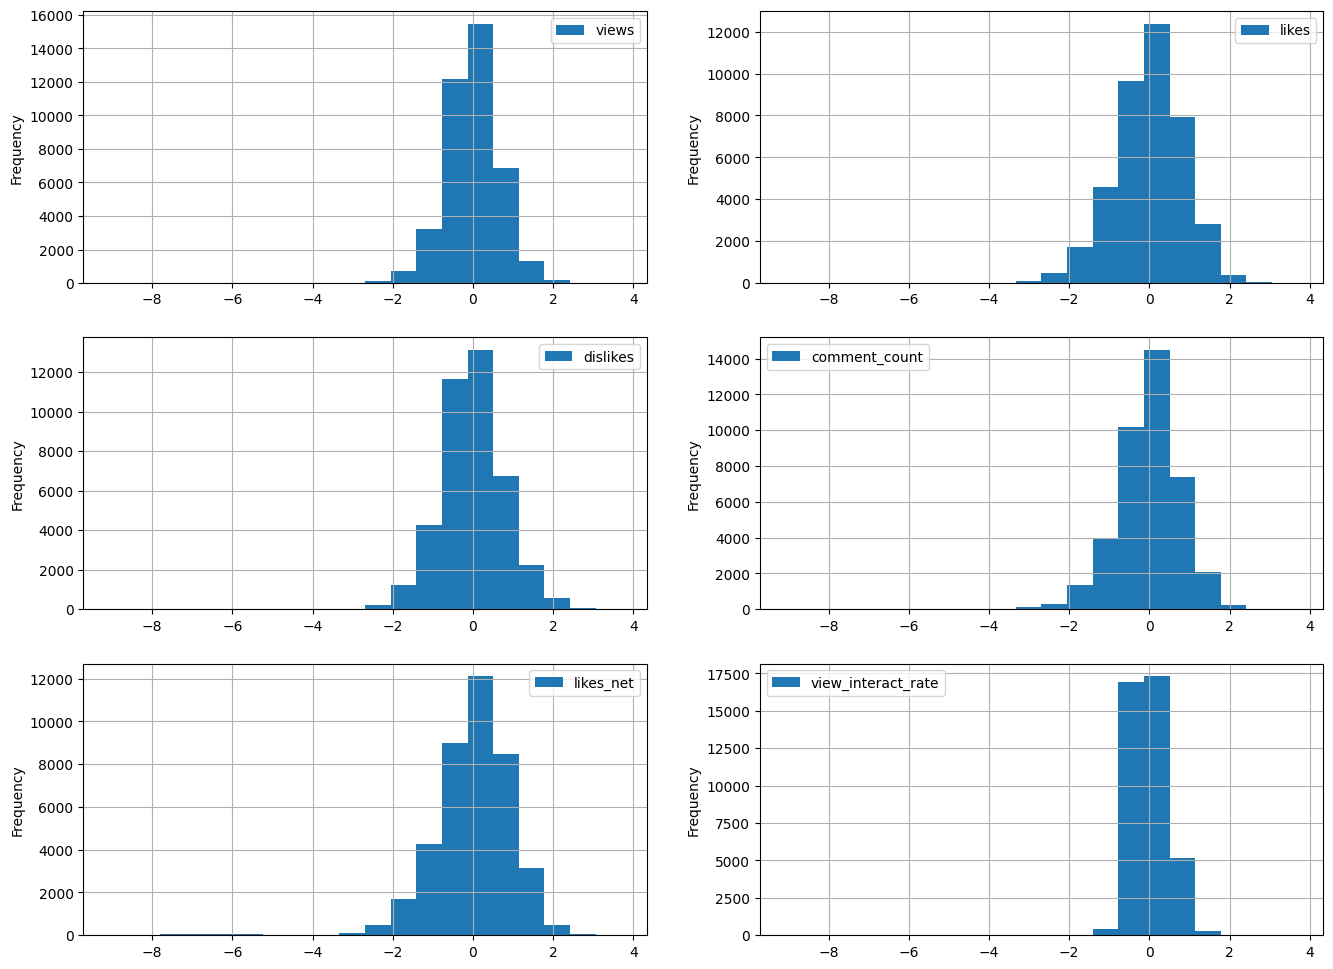

In [9]:
# Histogram of log(features). Mean shifted
fig, axs = plt.subplots(3,2, figsize=[16, 12])
df.plot.hist(column='views', bins=20, ax=axs[0, 0], grid=True)
df.plot.hist(column='likes', bins=20, ax=axs[0, 1], grid=True)
df.plot.hist(column='dislikes', bins=20, ax=axs[1, 0], grid=True)
df.plot.hist(column='comment_count', bins=20, ax=axs[1, 1], grid=True)
df.plot.hist(column='likes_net', bins=20, ax=axs[2, 0], grid=True)
df.plot.hist(column='view_interact_rate', bins=20, ax=axs[2, 1], grid=True)
# plt.savefig("feature_processed_distribution.png")

In [10]:
# Perform PCA on above columns
pca = PCA(n_components=6)
pca.fit(df[cols])
pca.components_

array([[-0.33770479, -0.49218155, -0.39524213, -0.41321669, -0.54759806,
         0.12994148],
       [ 0.39986942, -0.09211048,  0.57575185,  0.11943503, -0.57654033,
         0.39174793],
       [-0.35458693,  0.10584903,  0.05632061,  0.56101858, -0.47465909,
        -0.56555193],
       [-0.17522667,  0.33117542,  0.4755823 , -0.69124708, -0.10169177,
        -0.38115114],
       [ 0.45122972,  0.60763101, -0.53080281, -0.11645235, -0.36152129,
        -0.0341449 ],
       [ 0.60499205, -0.50909368, -0.03451525, -0.09413674,  0.03738311,
        -0.60279161]])

In [11]:
pca.explained_variance_

array([2.84202956e+00, 3.86938114e-01, 1.88463804e-01, 6.89921015e-02,
       4.75849563e-02, 6.63230753e-04])

In [12]:
pca.explained_variance_ratio_

array([8.04043415e-01, 1.09469320e-01, 5.33186154e-02, 1.95186728e-02,
       1.34623409e-02, 1.87635740e-04])

Text(0, 0.5, 'Accumulated explained variance ratio')

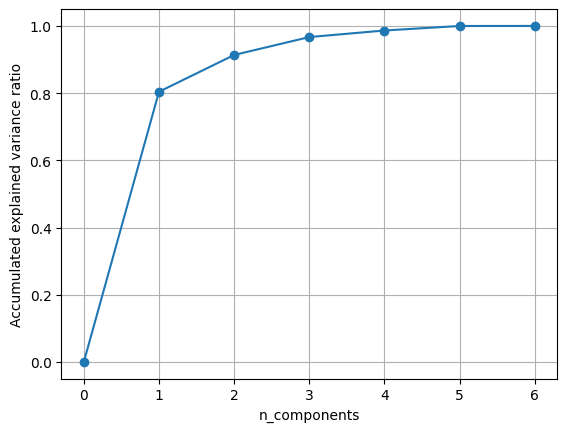

In [13]:
# Plot accumulated variance ratio vs n components
var_ratio_accumulate = [0.]
accum = 0
for x in pca.explained_variance_ratio_:
    accum += x
    var_ratio_accumulate.append(accum)
nums = list(range(len(var_ratio_accumulate)))
plt.plot(nums, var_ratio_accumulate, marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Accumulated explained variance ratio')
# plt.savefig('CAvideo_accumulated_explained_variance_ratio')

# We can see the first 3 principle components will explain 95% of the feature data variance

In [14]:
# Retrieve the dimension-reduced data
df_data = df[cols]
pc = pd.DataFrame()
for i in range(3):
    eigen_v = pd.Series(pca.components_[i])
    eigen_v.index = cols
    pc[f'PC{i+1}'] = df_data @ eigen_v
pc.describe()

,PC1,PC2,PC3
count,4.005500e+04,4.005500e+04,4.005500e+04
mean,1.702961e-17,3.122095e-16,-1.844874e-17
std,1.685832e+00,6.220435e-01,4.341242e-01
min,-6.094795e+00,-2.018065e+00,-2.498854e+00
25%,-1.090634e+00,-3.821692e-01,-2.483875e-01
50%,-7.056988e-02,-3.379468e-02,8.247728e-03
75%,1.003253e+00,3.340311e-01,2.264082e-01
max,7.320801e+00,7.603622e+00,5.707013e+00


In [15]:
pc[:10]

,PC1,PC2,PC3
0,-4.381894,0.646647,0.069193
1,-2.244156,-0.413973,0.381885
2,-2.522552,0.191707,-0.149966
3,-2.409413,-0.128369,0.178452
4,-4.621837,0.351171,-0.290614
5,-2.315822,0.018511,0.286114
6,-2.961423,0.257374,0.225580
7,-1.944907,-0.019536,0.549780
8,-3.137829,-0.012256,0.136795
9,0.086043,0.679926,-0.034449


### USvideos.csv

In [16]:
csv_path = "USvideos.csv"
csv_cols = ['video_id', 'channel_title', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']
data = pd.read_csv(csv_path, usecols=csv_cols)
valid_data = data.loc[(~data.comments_disabled) & (~data.ratings_disabled) & (~data.video_error_or_removed)]
df = valid_data.copy()
df = df.drop(columns=['comments_disabled', 'ratings_disabled', 'video_error_or_removed'])
print(len(df))
print(df.dtypes)

# All numeric features range [0, infinite], close to poisson distribution with lambda >> 10
df.describe()

40230
video_id         object
channel_title    object
views             int64
likes             int64
dislikes          int64
comment_count     int64
dtype: object


,views,likes,dislikes,comment_count
count,4.023000e+04,4.023000e+04,4.023000e+04,4.023000e+04
mean,2.360889e+06,7.522870e+04,3.734663e+03,8.594569e+03
std,7.416465e+06,2.307544e+05,2.927280e+04,3.774681e+04
min,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.442810e+05,5.634000e+03,2.070000e+02,6.540000e+02
50%,6.833000e+05,1.834000e+04,6.355000e+02,1.919000e+03
75%,1.820258e+06,5.606475e+04,1.935000e+03,5.900750e+03
max,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


In [17]:
# Deduce more features from existing numbers
# Net 'likes'
df['likes_net'] = df.likes - df.dislikes
# View count increment by every "interactivity" - likes, dislikes, comment count, and +1 to avoid divide 0
df['view_interact_rate'] = df.views / (df.likes + df.dislikes + df.comment_count + 1)
df.describe()

,views,likes,dislikes,comment_count,likes_net,view_interact_rate
count,4.023000e+04,4.023000e+04,4.023000e+04,4.023000e+04,4.023000e+04,40230.000000
mean,2.360889e+06,7.522870e+04,3.734663e+03,8.594569e+03,7.149404e+04,58.280829
std,7.416465e+06,2.307544e+05,2.927280e+04,3.774681e+04,2.192272e+05,218.018041
min,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-2.718420e+05,3.027944
25%,2.442810e+05,5.634000e+03,2.070000e+02,6.540000e+02,5.017250e+03,18.456409
50%,6.833000e+05,1.834000e+04,6.355000e+02,1.919000e+03,1.722300e+04,29.150633
75%,1.820258e+06,5.606475e+04,1.935000e+03,5.900750e+03,5.373825e+04,50.849591
max,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,5.406935e+06,10482.995146


In [18]:
# Take log10 for each numeric feature, well fits a normal distribution
cols = ['views', 'likes', 'dislikes', 'comment_count', 'likes_net', 'view_interact_rate']
for col in cols:
    col_min = df[col].min()
    if col_min < 0:
        df[col] = df[col].map(lambda x: np.log10(x) if x > 0 else -np.log10(-x+1))
        continue
    if col_min == 0:
        df[col] += 1
    df[col] = np.log10(df[col])
df.describe()

,views,likes,dislikes,comment_count,likes_net,view_interact_rate
count,40230.000000,40230.000000,40230.000000,40230.000000,40230.000000,40230.000000
mean,5.795420,4.193081,2.785894,3.260407,4.080876,1.511713
std,0.738133,0.875351,0.812514,0.802667,1.188200,0.365553
min,2.739572,0.000000,0.000000,0.000000,-5.434318,0.481148
25%,5.387890,3.750894,2.318063,2.816241,3.700466,1.266147
50%,5.834611,4.263423,2.803798,3.283301,4.236109,1.464648
75%,6.260133,4.748698,3.286905,3.770981,4.730284,1.706287
max,8.352591,6.749259,6.223865,6.134043,6.732951,4.020485


In [19]:
# Subtract mean for each feature, prepare for PCA
for col in cols:
    df[col] -= df[col].mean()
df.describe()

,views,likes,dislikes,comment_count,likes_net,view_interact_rate
count,4.023000e+04,4.023000e+04,4.023000e+04,4.023000e+04,4.023000e+04,4.023000e+04
mean,-7.912581e-17,1.582516e-16,3.165033e-16,2.486811e-16,-7.008286e-16,-2.613978e-17
std,7.381330e-01,8.753514e-01,8.125141e-01,8.026670e-01,1.188200e+00,3.655528e-01
min,-3.055848e+00,-4.193081e+00,-2.785894e+00,-3.260407e+00,-9.515194e+00,-1.030565e+00
25%,-4.075304e-01,-4.421872e-01,-4.678305e-01,-4.441658e-01,-3.804105e-01,-2.455655e-01
50%,3.919135e-02,7.034190e-02,1.790447e-02,2.289408e-02,1.552325e-01,-4.706469e-02
75%,4.647128e-01,5.556165e-01,5.010115e-01,5.105737e-01,6.494073e-01,1.945748e-01
max,2.557171e+00,2.556178e+00,3.437971e+00,2.873636e+00,2.652075e+00,2.508773e+00


<AxesSubplot: ylabel='Frequency'>

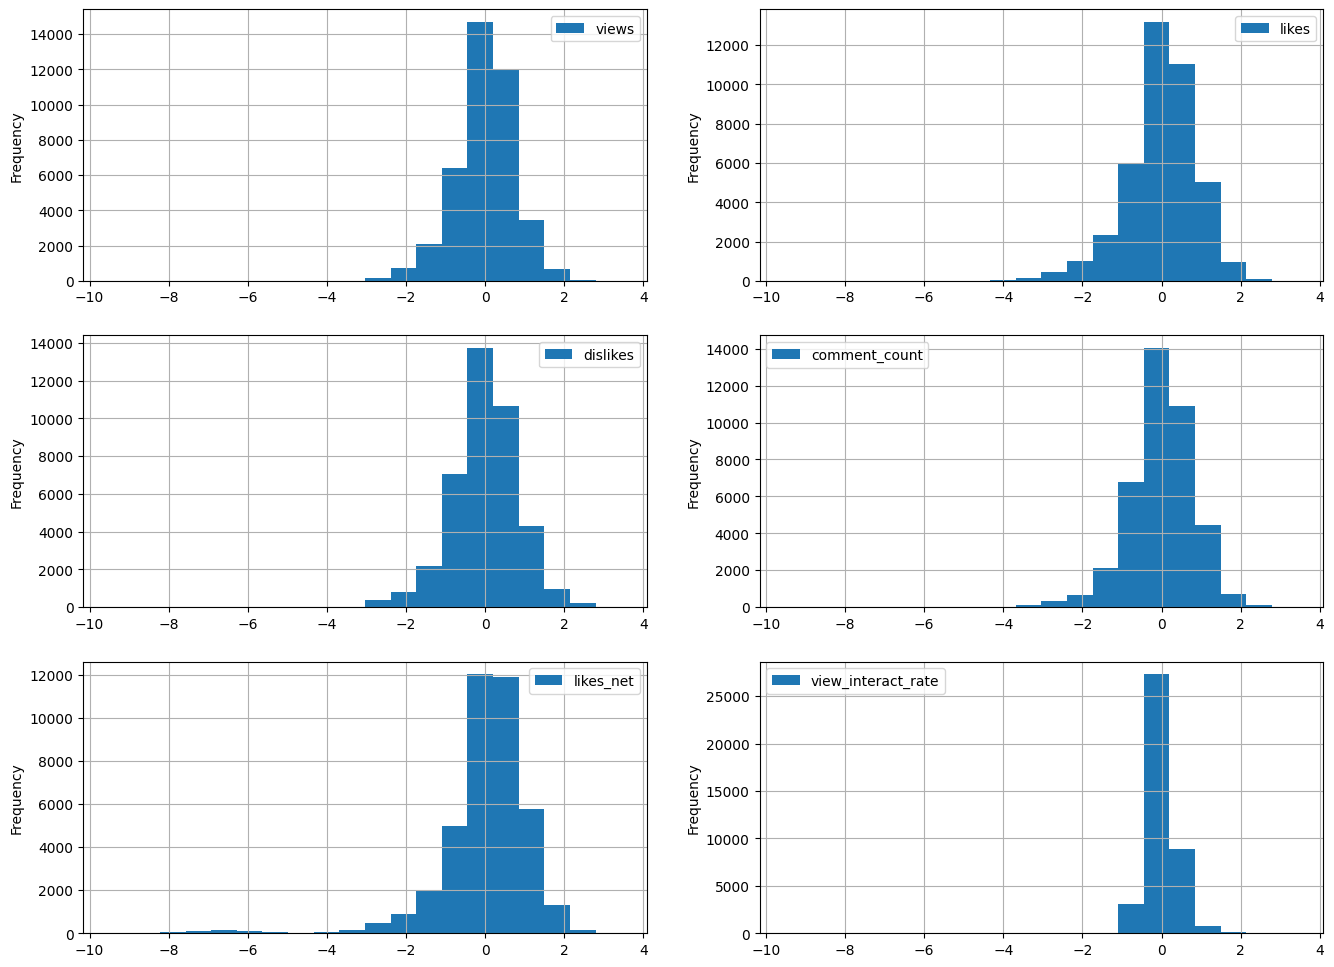

In [20]:
# Histogram of log(features). Mean shifted
fig, axs = plt.subplots(3,2, figsize=[16, 12])
df.plot.hist(column='views', bins=20, ax=axs[0, 0], grid=True)
df.plot.hist(column='likes', bins=20, ax=axs[0, 1], grid=True)
df.plot.hist(column='dislikes', bins=20, ax=axs[1, 0], grid=True)
df.plot.hist(column='comment_count', bins=20, ax=axs[1, 1], grid=True)
df.plot.hist(column='likes_net', bins=20, ax=axs[2, 0], grid=True)
df.plot.hist(column='view_interact_rate', bins=20, ax=axs[2, 1], grid=True)
# plt.savefig("feature_processed_distribution.png")

In [21]:
# Perform PCA on above columns
pca = PCA(n_components=6)
pca.fit(df[cols])
pca.components_

array([[-0.36894397, -0.46841186, -0.37872322, -0.40438513, -0.57564101,
         0.07841871],
       [ 0.25783375,  0.05100317,  0.52442992,  0.29698107, -0.74634166,
         0.10329599],
       [ 0.4841766 , -0.22800765,  0.08167388, -0.35369634,  0.17120772,
         0.7433046 ],
       [ 0.43879721,  0.46293156, -0.7122992 ,  0.1162052 , -0.2640479 ,
         0.05055967],
       [ 0.06503612,  0.49747076,  0.25796371, -0.7754923 , -0.10717634,
        -0.26243628],
       [ 0.60514663, -0.51402211, -0.03091816, -0.09100475,  0.03303635,
        -0.59937437]])

In [22]:
pca.explained_variance_

array([3.32789260e+00, 5.36376716e-01, 1.87951110e-01, 6.09768395e-02,
       4.72658012e-02, 5.18645304e-04])

In [23]:
pca.explained_variance_ratio_

array([7.99785442e-01, 1.28906290e-01, 4.51698958e-02, 1.46544358e-02,
       1.13592908e-02, 1.24644937e-04])

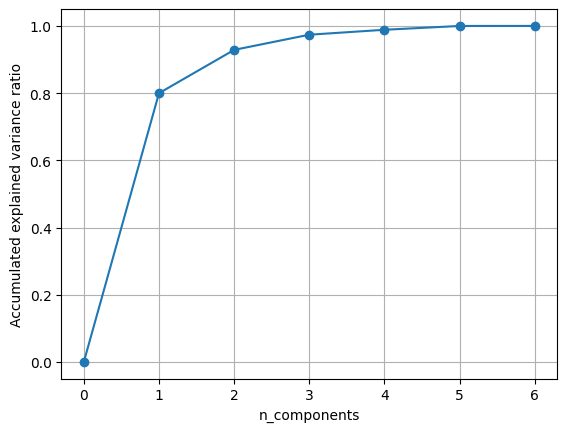

In [24]:
# Plot accumulated variance ratio vs n components
var_ratio_accumulate = [0.]
accum = 0
for x in pca.explained_variance_ratio_:
    accum += x
    var_ratio_accumulate.append(accum)
nums = list(range(len(var_ratio_accumulate)))
plt.plot(nums, var_ratio_accumulate, marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Accumulated explained variance ratio')
# plt.savefig('USvideo_accumulated_explained_variance_ratio')

# We can see the first 3 principle components will explain 95% of the feature data variance

In [25]:
# Retrieve the dimension-reduced data
df_data = df[cols]
pc = pd.DataFrame()
for i in range(3):
    eigen_v = pd.Series(pca.components_[i])
    eigen_v.index = cols
    pc[f'PC{i+1}'] = df_data @ eigen_v
pc.describe()

,PC1,PC2,PC3
count,4.023000e+04,4.023000e+04,4.023000e+04
mean,9.042950e-17,7.290878e-16,-2.741144e-16
std,1.824251e+00,7.323774e-01,4.335333e-01
min,-5.693833e+00,-1.492701e+00,-2.609034e+00
25%,-1.144079e+00,-3.353015e-01,-2.689587e-01
50%,-1.291542e-01,-8.807798e-02,-1.627337e-02
75%,8.875463e-01,2.013220e-01,2.505596e-01
max,7.792043e+00,1.025596e+01,2.735539e+00
